In [1]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os

# Setting up a Dask cluster

This notebook provides a starting place for setting up a dask cluster to spread your work across.

### Define Worker Cluster

Most of this can be left as is for most use cases. It's pretty optimized for Eagle. 

In [2]:
### modify memory/cores dependng on needs
n_processes = 24 # number of processes to run on each node
memory = 184000 # memory requested, you probably want a big memory node, so leave as is
# 184000: standard nodes
# 770000: short nodes
cluster = SLURMCluster(
    project=os.environ.get('SLURM_JOB_ACCOUNT'),
    walltime='60', # 2 hours for workers, you can make this more if you need it
    job_mem=str(memory),
    job_cpu=36,
    interface='ib0',
    local_directory='/tmp/scratch/dask-worker-space',
    cores=24, #18
    processes=n_processes,
    memory='{}MB'.format(memory),
    job_extra=['--qos=high']
)

This is the script that is submitted to slurm to start the workers. 

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A enduse
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=184000
#SBATCH -t 60
#SBATCH --qos=high

JOB_ID=${SLURM_JOB_ID%;*}

/home/lliu2/.conda-envs/notebookenv/bin/python -m distributed.cli.dask_worker tcp://10.148.0.110:38146 --nthreads 1 --nprocs 24 --memory-limit 7.67GB --name name --nanny --death-timeout 60 --local-directory /tmp/scratch/dask-worker-space --interface ib0



### Create the client

In [4]:
dask_client = Client(cluster)

### Scale the cluster

You tell the cluster how many workers you want with the `cluster.scale()` command. It will only start them in multiples of `n_processes` defined above (usually 18), so we can define the number of worker nodes (each with 18 processes) we want by multiplying that out. 

In [5]:
n_nodes = 8 # set this to the number of nodes you would like to start as workers
cluster.scale(n_processes * n_nodes)

This will show you your running jobs

In [6]:
!squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4160761     short dask-wor    lliu2 PD       0:00      1 (None)
           4160762     short dask-wor    lliu2 PD       0:00      1 (None)
           4160763     short dask-wor    lliu2 PD       0:00      1 (None)
           4160764     short dask-wor    lliu2 PD       0:00      1 (None)
           4160765     short dask-wor    lliu2 PD       0:00      1 (None)
           4160766     short dask-wor    lliu2 PD       0:00      1 (None)
           4160767     short dask-wor    lliu2 PD       0:00      1 (None)
           4160768     short dask-wor    lliu2 PD       0:00      1 (None)
           4160738     debug notebook    lliu2  R       1:57      1 r1i7n35


You can also see your workers by going to the [Dask Dashboard](http://localhost:8787/status). It's a nice way to see the progress of any running computation.

In [7]:
cluster.status

'running'

Now any work you have dask do will be scheduled across the nodes in your cluster. Do your work below.

# Initialize

In [7]:
import os
import re
import sys
import json
import pandas as pd
import functools
import itertools
import zipfile
import tempfile
import shutil
import pytz
import datetime as dt
from dask.distributed import Client, wait, LocalCluster
import dask.dataframe as dd
import dask
from dask import delayed
from dask import compute
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from getpass import getuser
import numpy as np
from dateutil.tz import tzoffset
from dateutil.relativedelta import relativedelta
import traceback
from IPython.display import HTML
from operator import itemgetter
import pickle
import dill
import math
from scipy.stats import gaussian_kde, linregress, norm
from scipy.stats import t as tstats
from scipy import optimize
import statistics as stats
import lmfit
from calendar import monthrange
import ruptures as rpt
from ruptures.utils import pairwise
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
import time
from multiprocessing import Pool
from sklearn.preprocessing import LabelBinarizer
import random
import scipy

#get_ipython().run_line_magic('matplotlib', 'inline')
#sns.set_style('whitegrid')
#sns.set_context('talk')
plt.style.use('default')

username = getuser()
username

'lliu2'

### Install packages here:

In [6]:
#pip install XX

### Load data

In [9]:
### directory

datadir = '/projects/enduse/ComEd_zipplus4_results'
scratchdir = '/scratch/{}'.format(username)
outdir = os.path.join(datadir,'DR_heating_cooling')
if not os.path.exists(outdir):
    os.mkdir(outdir)
print('ran')

ran


In [10]:
data_type = 'half_hourly' # <------ # hourly or half_hourly

DF = {}
for C in ['C23', 'C24', 'C25', 'C26']:
    DF[C] = pd.read_parquet(os.path.join(datadir,'ComEd_zipcode_{}_avg_w_temp_{}.parquet'.format(data_type, C)),
      engine='pyarrow')
    
display(DF['C26'])

,time,zip_code,mean,count,type,degC
0,2016-10-31 23:30:00,60002,0.327894,17.0,C26,5.00
1,2016-11-01 00:00:00,60002,0.300247,17.0,C26,5.60
2,2016-11-01 00:30:00,60002,0.223218,17.0,C26,6.15
3,2016-11-01 01:00:00,60002,0.243218,17.0,C26,6.70
4,2016-11-01 01:30:00,60002,0.254665,17.0,C26,7.30
...,...,...,...,...,...,...
4236483,2017-03-31 21:00:00,61114,0.605947,693.0,C26,5.20
4236484,2017-03-31 21:30:00,61114,0.603785,693.0,C26,4.45
4236485,2017-03-31 22:00:00,61114,0.584793,693.0,C26,3.70
4236486,2017-03-31 22:30:00,61114,0.572194,693.0,C26,2.95


### FFT and model prep Functions

In [11]:
def fftval(y_values, T, N):
    # fast fourier transform
    # freq = np.linspace(0.0, 1.0/(2.0*T), N//2) # 0~1
    spectrum = scipy.fftpack.fft(y_values)
    freq = scipy.fftpack.fftfreq(len(spectrum), 1)[0:N//2] # per interval T
    fft_mag = 2.0/N * np.abs(spectrum[0:N//2]) # all pos.
    fft_phase = np.angle(spectrum[0:N//2]) # radians
    return freq, fft_mag, fft_phase
    
def clean_data(tx, signal):
    ### remove nan values
    tx = tx[~np.isnan(signal)]
    signal = signal[~np.isnan(signal)]
    
    ### interpolate to fill gap in case there is any
    # f = scipy.interpolate.interp1d(tx, signal)
    # tx = np.arange(tx.min(), tx.max()+0.5, 0.5)
    # signal = f(tx)    

    return tx, signal

def get_fft_values(time, signal):
    
    N = len(signal)
    deltT = time[1] - time[0] # time interval
    #fs = 1/deltT
    freq, fft_mag, fft_phase = fftval(signal, deltT, N)
    return freq, fft_mag, fft_phase    

def get_sorted_fft(t, yy):
    """
    input:
        t: array, time index (e.g. [0, 0.5, 1, ...])
        yy: array, signal
        
    output:
        output: df with FFT 'magnitude', 'period' [hr], 'phase', 'cos coeff'', 
        and 'sin coeff'' sorted by descending mag
    """
    tx, signal = clean_data(t, yy)
    freq, fft_mag, fft_phase = get_fft_values(tx, signal)
    
    # take only those with positive freq
    i = freq >= 0
    freq, fft_mag, fft_phase = freq[i], fft_mag[i], fft_phase[i]
    
    ### get power-freq table and sort
    PF = pd.DataFrame()
    PF['freq']=freq
    PF['mag']=fft_mag
    # get period [hr], use 0.5 because interval = 0.5
    PF['period'] = np.divide(0.5, freq, out=np.zeros_like(freq), where=freq!=0)
    PF['phase'] = fft_phase
    PF['cos coeff'] = PF['mag']*np.cos(PF['phase'])
    PF['sin coeff'] = PF['mag']*np.sin(PF['phase'])
    PF_sorted = PF.sort_values(by='mag', ascending=False).reset_index(drop=True)
        
    return PF_sorted

def plot_fft_plus_power(tx, signal, signal_type, zipcode, filter_type='top4', log_transform=True):
    global service_type
    # n: number of +sigmas from mean as the LB to qualify the coeff corresponding to the amplitude or fft_values
    # @ n=0, p(amp > mean+nstd) = 0.5
    # @ n=1, p(amp > mean+nstd) = 0.16
    # @ n=1.65, p(amp > mean+nstd) = 0.05
    # @ n=2.33, p(amp > mean+nstd) = 0.01
    
    tx, signal = clean_data(tx, signal)
    print(len(signal))
    
    
    freq, fft_mag, fft_phase = get_fft_values(tx, signal)
    
    fft_power = np.abs(fft_mag) ** 2
    fft_freq = scipy.fftpack.fftfreq(len(fft_power), 1/24) # per day
    
    ### get power-freq table and save
    PF = pd.DataFrame()
    PF['power']=fft_power
    PF['phase'] = fft_phase
    PF['freq per day'] = fft_freq
    PF['freq per year'] = fft_freq*8784/24
    PF['period'] = np.divide(24, fft_freq, out=np.zeros_like(fft_freq), where=fft_freq!=0) #['hr']
    PF_sorted = PF.sort_values(by='power', ascending=False).reset_index(drop=True)
    
    # ### 1) fast fourier transform
    # # not quite useful
    # fig, ax = plt.subplots(figsize=(5, 3))
    # ax.plot(freq, fft_mag, 'r-', label='Fourier Transform')
    # ax.plot(f_val, fft_val, 'ro')
    # ax.plot(freq, variance*fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    # ax.set_xlabel('Frequency (cycle per {})'.format(tx_unit), fontsize=12)
    # ax.set_ylabel('Amplitude', fontsize=12)
    # ax.legend()
    
    ### 2) power spectral density
    # useful
    fig2, ax2 = plt.subplots(figsize=(5, 3))
    i = fft_freq > 0 # get only positive freq
    ax2.plot(fft_freq[i], fft_power[i],'-', label=signal_type)
    ax2.set_xlabel('Frequency (1/day)')
    ax2.set_ylabel('power spectral density')
    ax2.legend()
    ax2.set_title('{}: {}'.format(service_type, zipcode))
    
    ### 3) plot time series with main frequency    
    fft_mod = scipy.fftpack.fft(signal)
    fft_year = scipy.fftpack.fftfreq(len(fft_mod), 1./len(signal)) # set freq unit to 'year' [0, 1, 2, ....]
    fft_day = scipy.fftpack.fftfreq(len(fft_mod), 1. / 24) # set freq unit to 'day'
    
    # modify magitudes by filtering out non-important freq
    # (1) taking main freq up to 2 (12 hr or more) from FFT
#    fft_mod[np.abs(fft_day) > 2.1] = 0 
    
    maxP = len(signal)//2-1 # max period
    f_hr = np.divide(maxP, fft_year, out=np.zeros_like(fft_year), where=fft_year!=0).round(2)
    
    if filter_type == 'top4':
    # (3) # take coeff of top 4 mag
        lb = min(sorted(np.abs(fft_mod), reverse=True)[:9]) # top 4 + constant at 0
        fft_mod[np.abs(fft_mod)<lb] = 0 
    else:
    # (2) # take coeff at year (0 freq), 7 days , 24hr, & 12hr
        fft_mod[(np.abs(f_hr)!=0)&(np.abs(f_hr)!=24*7)&(np.abs(f_hr.round(1))!=24)&(np.abs(f_hr)!=12)] = 0 
    
    len(fft_mod)
    len(fft_mod[fft_mod!=0])
    print(fft_mod[fft_mod!=0]) # spectrum of top 5 mag
    print([i for i, e in enumerate(fft_mod) if e != 0]) # check index where elements are not 0
    
    # week: f_hr.round(0)==169

    signal_filtered = np.real(scipy.fftpack.ifft(fft_mod)) # reconstruct time domain data based on modified/filtered FFT

    fig3, ax3 = plt.subplots(figsize=(5, 3))
    ax3.plot(tx, signal, lw=2, alpha=1, label='data (# hrs: {})'.format(len(signal)/2))
    lab = 'filtered (top 4 periods [hr]:\n'+\
        '{}, {}, {}, {})'.format(round(PF_sorted['period'][1],1),round(PF_sorted['period'][2],1),
                                    round(PF_sorted['period'][3],1),round(PF_sorted['period'][4],1))
    ax3.plot(tx, signal_filtered, lw=0.5, alpha=0.8, label=lab)
    ax3.set_xlabel('hour')
    if signal_type == 'demand':
        lab = 'log(demand (W))' if log_transform else 'demand (W)'
        ax3.set_ylabel(lab)
    else:
        lab = 'log(temp(degC))' if log_transform else 'temp (degC)'
        ax3.set_ylabel(lab)
    ax3.legend()
    ax3.margins(x=0)
    ax3.set_title('{}: {}'.format(service_type, zipcode))

# % [4B] functions for model prep
def get_avg_kW_by_degC(dfi):
    global log_transform
    
    df2 = dfi.copy()
    df2['x'] = round(df2['x'],0)
    df2 = df2.groupby(['x']).mean().rolling(3).mean().dropna() # avg series and smoothed
    
    # specify model
    model = lmfit.Model(piecewise_linear, independent_vars=['x'])
    
    x0_list = df2.sort_values(by=['y']).head(5).index
    D = {'r2':[],'res':[]}
    for x0 in x0_list:
        params = lmfit.Parameters()
        params.add('x0', value=x0, vary=False) #min=df2.index.min(), max=df2.index.max(), value=np.array(df2.index).mean())
        # params.add('x0', min=df2.index.min(), max=df2.index.max(), value=np.array(df2.index).mean())
        params.add('b0', min=df2['y'].min()-1, max=df2['y'].max())
        params.add('mh', min=-5, max=0)
        params.add('mc', min=0, max=5)
        
        res = model.fit(df2['y'], params, x=df2.index, method='powell', nan_policy='omit')
        
        R2 = rsq(df2['y'],res.best_fit)
        D['r2'].append(R2)
        D['res'].append(res)
        
    key = np.argmax(D['r2']) # where best fit occur
    res = D['res'][key]
    V = res.best_values
        
    fig, ax = plt.subplots()
    ax.scatter(df2.index, df2['y'], label='demand by temp bins\n(smoothed (3))')
    ax.plot(df2.index, res.best_fit, color='tab:orange', label='best fit:\nx0: {}\nR2: {}'.format(V['x0'], round(D['r2'][key],4)))
    ax.set_xlabel('temperature (degC)')
    ylab = 'ln(demand (W))' if log_transform else 'demand (W)'
    ax.set_ylabel(ylab)
    ax.legend()
    
    return round(V['x0'],0), V['b0'], V['mh'], V['mc']

print('Model preprocessing funcs ran.')    

Model preprocessing funcs ran.


### Model math funcs

In [12]:
def linear(x, a0, a1):
    return a0 + a1*x

def linearc(x, a0, a1, x0):
    return a0 + a1*(x-x0)

def cubic(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*(x**2) + a3*(x**3)

def quartic(x, a0, a1, a2, a3, a4):
    return a0 + a1*x + a2*(x**2) + a3*(x**3) + a4*(x**4)

def quintic(x, a0, a1, a2, a3, a4, a5):
    a1 *= 1e-1; a2 *= 1e-2; a3 *= 1e-3; a4 *= 1e-4; a5 *= 1e-5;
    return a0 + a1*x + a2*(x**2) + a3*(x**3) + a4*(x**4) + a5*(x**5)

def logistic(x, L, k, x0, b0):
    return L/(1+np.exp(-k*(x-x0)))+b0

def fourier1(t, p, c, a1, b1):
    # 2pi/w = p or period or cycle length (e.g. 24-hr)
    # if p, cycle = 24hr, then:
    # a1, b1 = effects at 24-hr cycle (24/1), larger val = stronger effects
    # a2, b2 = effects at 12-hr cycle, (24/2)...
    
    w = 2*np.pi/p # in radian
    return c + a1*np.cos(t*w) + b1*np.sin(t*w)

def fourier2(t, p, c, a1, b1, a2, b2):
    # 2pi/w = p or period or cycle length (e.g. 24-hr)
    # if p, cycle = 24hr, then:
    # a1, b1 = effects at 24-hr cycle (24/1), larger val = stronger effects
    # a2, b2 = effects at 12-hr cycle, (24/2)...
    
    w = 2*np.pi/p # in radian
    # w: 24 hr;  2w: 12 hr
    return c + a1*np.cos(t*w) + b1*np.sin(t*w) + a2*np.cos(2*t*w) + b2*np.sin(2*t*w)

def fourier3(t, p, c, a1, b1, a2, b2, a3, b3, k2, k3):
    w = 2*np.pi/p # in radian
    return c + a1*np.cos(t*w) + b1*np.sin(t*w) + a2*np.cos(k2*t*w) + b2*np.sin(k2*t*w) +\
            a3*np.cos(k3*t*w) + b3*np.sin(k3*t*w)

def fourier14(t, p, c, a1, b1, a7, b7, a14, b14):
    w = 2*np.pi/p # in radian
    # w: 1 week; 7w: 24 hr;  14w: 12 hr
    return c + a1*np.cos(t*w) + b1*np.sin(t*w) + a7*np.cos(7*t*w) + b7*np.sin(7*t*w) +\
            a14*np.cos(14*t*w) + b14*np.sin(14*t*w)
            
def fourier_top4(t, p, c, a1, b1, a2, b2, a3, b3, a4, b4, k2, k3, k4):
    w = 2*np.pi/p # in radian
    # w: 1 year; 2w: half year;  366w: 24hr; 732w: 12 hr
    return c + a1*np.cos(t*w)+b1*np.sin(t*w) + a2*np.cos(k2*t*w)+b2*np.sin(k2*t*w) +\
            a3*np.cos(k3*t*w)+b3*np.sin(k3*t*w) + a4*np.cos(k4*t*w)+b4*np.sin(k4*t*w)

def fourier_top8(t, p, c, a1, b1, a2, b2, a3, b3, a4, b4, 
                  a5, b5, a6, b6, a7, b7, a8, b8,
                  k2, k3, k4, k5, k6, k7, k8):
    w = 2*np.pi/p # in radian
    # w: 1 year; 2w: half year;  366w: 24hr; 732w: 12 hr
    return c + a1*np.cos(t*w)+b1*np.sin(t*w) + a2*np.cos(k2*t*w)+b2*np.sin(k2*t*w) +\
            a3*np.cos(k3*t*w)+b3*np.sin(k3*t*w) + a4*np.cos(k4*t*w)+b4*np.sin(k4*t*w) +\
                a5*np.cos(k5*t*w)+b5*np.sin(k5*t*w) + a6*np.cos(k6*t*w)+b6*np.sin(k6*t*w) +\
                    a7*np.cos(k7*t*w)+b7*np.sin(k7*t*w) + a8*np.cos(k8*t*w)+b8*np.sin(k8*t*w)

def piecewise_linear(x, x0, b0, mh, mc):
    condlist = [x<=x0] # + else
    funclist = [mh*(x-x0)+b0, mc*(x-x0)+b0]
    return np.where(condlist[0], funclist[0], funclist[1])
    
def rsq(data,model):
    return (np.corrcoef(data,model)[0,1])**2


################################################
def load_pickle(name):
    """ Function to load an object from a pickle """
    with open(f'{name}.pkl', 'rb') as f:
        temp = pickle.load(f)
    return temp


def save_pickle(contents, name):
    """ Function to save to an object as a pickle """
    with open(f'{name}.pkl', 'wb') as output:
        pickle.dump(contents, output, pickle.HIGHEST_PROTOCOL)


def load_dill(name):
    """ Function to load an object from a dill """
    with open(f'{name}.dll', 'rb') as f:
        temp = dill.load(f)
    return temp


def save_dill(contents, name):
    """ Function to save to an object as a dill """
    with open(f'{name}.dll', 'wb') as output:
        dill.dump(contents, output, dill.HIGHEST_PROTOCOL)

print('Model math and pickle/dill functions ran.')

Model math and pickle/dill functions ran.


### Model funcs 2

In [13]:
def linear_fourier_top4(x, y, t, # data
                    xh, yh, xc, yc, # domain bounds
                    mh, bh, mc, bc, # heat/cool lines
                    b0, b1c, b1s, b2c, b2s, b3c, b3s, b4c, b4s, # fourier 0 HVAC-off reg
                    bh0, bh1c, bh1s, bh2c, bh2s, bh3c, bh3s, bh4c, bh4s, # fourier heat
                    bc0, bc1c, bc1s, bc2c, bc2s, bc3c, bc3s, bc4c, bc4s, # fourier cool reg
                    p, ph, pc, k2, k3, k4, kh2, kh3, kh4, kc2, kc3, kc4, # fourier period and fourier term multiplers
                    modtype='B'):
    global tseason
    
    # domain-wise regressions
    l0 = fourier_top4(t, p, b0, b1c, b1s, b2c, b2s, b3c, b3s, b4c, b4s, k2, k3, k4) # HVAC-off domain
    lh = linearc(x, bh, mh, xh)*fourier_top4(t, ph, bh0, bh1c, bh1s, bh2c, bh2s, bh3c, bh3s, bh4c, bh4s, kh2, kh3, kh4) # heat domain
    lc = linearc(x, bc, mc, xc)*fourier_top4(t, pc, bc0, bc1c, bc1s, bc2c, bc2s, bc3c, bc3s, bc4c, bc4s, kc2, kc3, kc4) # cool domain
    if modtype != 'A':
        lh = lh + l0
        lc = lc + l0
        
    condlist = [(x<xh) & (y>yh) & ((t<tseason[0])|(t>=tseason[3])), 
                (x>xc) & (y>yc) & (t>=tseason[1]) & (t<tseason[2])] # + else
    funclist = [lh, lc, l0]
    return np.where(condlist[0], funclist[0], 
                    np.where(condlist[1], funclist[1], funclist[2]))  

def HVAC_demands_linear_fourier_top4(x, y, t, tidx, V, log_transform=True, modtype='B'):
    global tseason
    
    Hfilt = (x<V['xh'])&(y>V['yh']) & ((t<tseason[0])|(t>=tseason[3]))
    Xh = x[Hfilt]; Th = t[Hfilt]; tidxh = tidx[Hfilt];
    l0h = fourier_top4(Th, V['p'], V['b0'], V['b1c'], V['b1s'], V['b2c'], V['b2s'], 
                       V['b3c'], V['b3s'],V['b4c'], V['b4s'], 
                       V['k2'], V['k3'], V['k4']) # HVAC-off domain
    lh = linearc(Xh, V['bh'], V['mh'], V['xh']) * fourier_top4(Th, V['ph'], V['bh0'], 
                    V['bh1c'], V['bh1s'], V['bh2c'], V['bh2s'], V['bh3c'], V['bh3s'], 
                    V['bh4c'], V['bh4s'], V['kh2'], V['kh3'], V['kh4']) # heat domain
    
    Cfilt = (x>V['xc']) & (y>V['yc']) & (t>=tseason[1]) & (t<tseason[2])    
    Xc = x[Cfilt]; Tc = t[Cfilt]; tidxc = tidx[Cfilt];
    l0c = fourier_top4(Tc, V['p'], V['b0'], V['b1c'], V['b1s'], V['b2c'], V['b2s'], 
                       V['b3c'], V['b3s'], V['b4c'], V['b4s'],
                       V['k2'], V['k3'], V['k4']) # HVAC-off domain
    lc = linearc(Xc, V['bc'], V['mc'], V['xc']) * fourier_top4(Tc, V['pc'], V['bc0'], 
                    V['bc1c'], V['bc1s'], V['bc2c'], V['bc2s'], V['bc3c'], V['bc3s'], 
                    V['bc4c'], V['bc4s'], V['kc2'], V['kc3'], V['kc4']) # cool domain
    
    if log_transform:
        # need to back-transform
        if modtype == 'A':
            lh = np.exp(lh) - np.exp(l0h)
            lc = np.exp(lc) - np.exp(l0c)
        else:
            lh = np.exp(lh+l0h) - np.exp(l0h)
            lc = np.exp(lc+l0c) - np.exp(l0c)
    else:
        if modtype == 'A':
            lh -= l0h
            lc -= l0c
    return [tidxh, tidxc], [Xh, Xc], [lh, lc]

def linear_fourier_top4_24_12(x, y, t, # data
                    xh, yh, xc, yc, # domain bounds
                    mh, bh, mc, bc, # heat/cool lines
                    b0, b1c, b1s, b2c, b2s, b3c, b3s, b4c, b4s, # fourier 0 HVAC-off reg
                    bh0, bh1c, bh1s, bh2c, bh2s, # fourier heat
                    bc0, bc1c, bc1s, bc2c, bc2s, # fourier cool reg
                    p, ph, pc, k2, k3, k4, # fourier period and fourier term multiplers
                    modtype='B'):
    global tseason
    
    # domain-wise regressions
    l0 = fourier_top4(t, p, b0, b1c, b1s, b2c, b2s, b3c, b3s, b4c, b4s, k2, k3, k4) # HVAC-off domain
    lh = linearc(x, bh, mh, xh)*fourier2(t, ph, bh0, bh1c, bh1s, bh2c, bh2s) # heat domain
    lc = linearc(x, bc, mc, xc)*fourier2(t, pc, bc0, bc1c, bc1s, bc2c, bc2s) # cool domain
    #if modtype != 'A':
    lh = lh + l0
    lc = lc + l0
        
    condlist = [(x<xh) & (y>yh) & ((t<tseason[0])|(t>=tseason[3])), 
                (x>xc) & (y>yc) & (t>=tseason[1]) & (t<tseason[2])] # + else
    funclist = [lh, lc, l0]
    return np.where(condlist[0], funclist[0], 
                    np.where(condlist[1], funclist[1], funclist[2]))  

def HVAC_demands_linear_fourier_top4_24_12(x, y, t, tidx, V, log_transform=True, modtype='B'):
    global tseason
    
    Hfilt = (x<V['xh'])&(y>V['yh']) & ((t<tseason[0])|(t>=tseason[3]))
    Xh = x[Hfilt]; Th = t[Hfilt]; tidxh = tidx[Hfilt];
    l0h = fourier_top4(Th, V['p'], V['b0'], V['b1c'], V['b1s'], V['b2c'], V['b2s'], 
                       V['b3c'], V['b3s'],V['b4c'], V['b4s'], 
                       V['k2'], V['k3'], V['k4']) # HVAC-off domain
    lh = linearc(Xh, V['bh'], V['mh'], V['xh']) * fourier2(Th, V['ph'], V['bh0'], 
                    V['bh1c'], V['bh1s'], V['bh2c'], V['bh2s']) # heat domain
        
    Cfilt = (x>V['xc']) & (y>V['yc']) & (t>=tseason[1]) & (t<tseason[2])    
    Xc = x[Cfilt]; Tc = t[Cfilt]; tidxc = tidx[Cfilt];
    l0c = fourier_top4(Tc, V['p'], V['b0'], V['b1c'], V['b1s'], V['b2c'], V['b2s'], 
                       V['b3c'], V['b3s'], V['b4c'], V['b4s'],
                       V['k2'], V['k3'], V['k4']) # HVAC-off domain
    lc = linearc(Xc, V['bc'], V['mc'], V['xc']) * fourier2(Tc, V['pc'], V['bc0'], 
                    V['bc1c'], V['bc1s'], V['bc2c'], V['bc2s']) # cool domain
    
    if log_transform:
        # need to back-transform
        if modtype == 'A':
            lh = np.exp(lh) - np.exp(l0h)
            lc = np.exp(lc) - np.exp(l0c)
        else:
            lh = np.exp(lh+l0h) - np.exp(l0h)
            lc = np.exp(lc+l0c) - np.exp(l0c)
    else:
        if modtype == 'A':
            lh -= l0h
            lc -= l0c
    return [tidxh, tidxc], [Xh, Xc], [lh, lc]

def linear_fourier_top8_24_12(x, y, t, # data
                    xh, yh, xc, yc, # domain bounds
                    mh, bh, mc, bc, # heat/cool lines
                    b0, b1c, b1s, b2c, b2s, b3c, b3s, b4c, b4s,  # fourier 0 HVAC-off reg
                    b5c, b5s, b6c, b6s, b7c, b7s, b8c, b8s,
                    bh0, bh1c, bh1s, bh2c, bh2s, # fourier heat
                    bc0, bc1c, bc1s, bc2c, bc2s, # fourier cool reg
                    p, ph, pc, k2, k3, k4, k5, k6, k7, k8, # fourier period and fourier term multiplers
                    modtype='B'):
    global tseason
    
    # domain-wise regressions
    l0 = fourier_top8(t, p, b0, b1c, b1s, b2c, b2s, b3c, b3s, b4c, b4s, 
                      b5c, b5s, b6c, b6s, b7c, b7s, b8c, b8s,
                      k2, k3, k4, k5, k6, k7, k8) # HVAC-off domain
    lh = linearc(x, bh, mh, xh)*fourier2(t, ph, bh0, bh1c, bh1s, bh2c, bh2s) # heat domain
    lc = linearc(x, bc, mc, xc)*fourier2(t, pc, bc0, bc1c, bc1s, bc2c, bc2s) # cool domain
    if modtype != 'A':
        lh = lh + l0
        lc = lc + l0
        
    condlist = [(x<xh) & (y>yh) & ((t<tseason[0])|(t>=tseason[3])), 
                (x>xc) & (y>yc) & (t>=tseason[1]) & (t<tseason[2])] # + else
    funclist = [lh, lc, l0]
    return np.where(condlist[0], funclist[0], 
                    np.where(condlist[1], funclist[1], funclist[2]))  

def HVAC_demands_linear_fourier_top8_24_12(x, y, t, tidx, V, log_transform, modtype='B'):
    global tseason
    
    Hfilt = (x<V['xh'])&(y>V['yh']) & ((t<tseason[0])|(t>=tseason[3]))
    Xh = x[Hfilt]; Th = t[Hfilt]; tidxh = tidx[Hfilt];
    l0h = fourier_top8(Th, V['p'], V['b0'], V['b1c'], V['b1s'], V['b2c'], V['b2s'], 
                       V['b3c'], V['b3s'],V['b4c'], V['b4s'], 
                       V['b5c'], V['b5s'], V['b6c'], V['b6s'], 
                       V['b7c'], V['b7s'],V['b8c'], V['b8s'], 
                       V['k2'], V['k3'], V['k4'],V['k5'], V['k6'], V['k7'], V['k8']) # HVAC-off domain
    lh = linearc(Xh, V['bh'], V['mh'], V['xh']) * fourier2(Th, V['ph'], V['bh0'], 
                    V['bh1c'], V['bh1s'], V['bh2c'], V['bh2s']) # heat domain
    
    Cfilt = (x>V['xc']) & (y>V['yc']) & (t>=tseason[1]) & (t<tseason[2])    
    Xc = x[Cfilt]; Tc = t[Cfilt]; tidxc = tidx[Cfilt];
    l0c = fourier_top8(Tc, V['p'], V['b0'], V['b1c'], V['b1s'], V['b2c'], V['b2s'], 
                       V['b3c'], V['b3s'],V['b4c'], V['b4s'], 
                       V['b5c'], V['b5s'], V['b6c'], V['b6s'], 
                       V['b7c'], V['b7s'],V['b8c'], V['b8s'], 
                       V['k2'], V['k3'], V['k4'],V['k5'], V['k6'], V['k7'], V['k8']) # HVAC-off domain
    lc = linearc(Xc, V['bc'], V['mc'], V['xc']) * fourier2(Tc, V['pc'], V['bc0'], 
                    V['bc1c'], V['bc1s'], V['bc2c'], V['bc2s']) # cool domain
    
    if log_transform:
        # need to back-transform
        if modtype == 'A':
            lh = np.exp(lh) - np.exp(l0h)
            lc = np.exp(lc) - np.exp(l0c)
        else:
            lh = np.exp(lh+l0h) - np.exp(l0h)
            lc = np.exp(lc+l0c) - np.exp(l0c)
    else:
        if modtype == 'A':
            lh -= l0h
            lc -= l0c
    return [tidxh, tidxc], [Xh, Xc], [lh, lc]

print(' "linear_fourier models" and "get HVAC load models" ran.')

 "linear_fourier models" and "get HVAC load models" ran.


### Post processing funcs

In [14]:
### for post processing
def divide_best_fit(xx, yy, t, idx, best_fit, best_val):
    global tseason
    
    df = best_fit
    r = best_val
    
    Hfilt = (yy>r['yh']) & (xx<r['xh']) & ((t<tseason[0])|(t>=tseason[3]))
    Cfilt = (yy>r['yc']) & (xx>r['xc']) & (t>=tseason[1]) & (t<tseason[2])
    Ofilt = ~(Hfilt | Cfilt)
    
    dfh = df[Hfilt]
    dfc = df[Cfilt]
    dfo = df[Ofilt] 
    
    xxh = xx[Hfilt]
    xxc = xx[Cfilt]
    xxo = xx[Ofilt]
    
    idxh = np.array(idx[Hfilt])
    idxc = np.array(idx[Cfilt])
    idxo = np.array(idx[Ofilt]) 
    
    return [idxh, idxc, idxo], [xxh, xxc, xxo], [dfh, dfc, dfo]

### plot func
def plot_output(xx, yy, t, tidx, best_fit, best_val, HVAC_only):
    global df_demand, log_transform
    
    IDX, XX, BF = divide_best_fit(xx, yy, t, tidx, best_fit, best_val) # time
    V = best_val
    
    fig = plt.figure(figsize=(10,9))
    
    ylab = 'ln(demand (W))' if log_transform else 'demand (W)'
    # % 1) temp-demand plot
    ax1 = fig.add_subplot(3,2,1)
    ax1.scatter(xx, yy, color='grey', s=1)
    ax1.scatter(XX[2], BF[2], color='tab:blue', s=2, alpha=0.8) # HVAC-off domain
    ax1.scatter(XX[0], BF[0], color='m', s=2, alpha=0.8) # heating domain
    ax1.scatter(XX[1], BF[1], color='c', s=2, alpha=0.8) # cooling domain
    ax1.axvline(V['xh'],linestyle='-.',color='r')
    xhl, xhu = plt.gca().get_xlim()[0],plt.gca().get_xlim()[1]
    ax1.axhline(V['yh'],0,(V['xh']-xhl)/(xhu-xhl), linestyle='--',color='darkviolet')
    
    ax1.axvline(V['xc'], linestyle='-.',color='b')
    xcl, xcu = plt.gca().get_xlim()[0],plt.gca().get_xlim()[1]
    ax1.axhline(V['yc'],(V['xc']-xcl)/(xcu-xcl),1, linestyle='--',color='darkviolet')
    ax1.set_ylabel(ylab)
    ax1.set_title('Temp - demand')
    
    # % 2) time series - kwh
    ax2 = fig.add_subplot(3,2,2, sharey=ax1)
    ax2.scatter(tidx, yy, color='grey', label='data', s=1)
    
    leg_title = 'Best fit stats:\n'+\
                'R2: {}\n'.format(round(V['r2'],4))+\
                'chi-sq: {}\n'.format(round(V['chisqr'],1))+\
                'AIC: {}\n'.format(round(V['aic'],1))+\
                '%data: {}\n'.format(round(len(yy)/len(df_demand)*100,1))
    lab2h = 'Heating\n'+\
            'mh: {}\n'.format(round(V['mh'],4))+\
            'bh: {}'.format(round(V['bh'],2))
    lab2c = 'Cooling\n'+\
            'mc: {}\n'.format(round(V['mc'],4))+\
            'bc: {}'.format(round(V['bc'],2))
            
            
    ax2.scatter(IDX[2], BF[2], color='tab:blue', label='HVAC-off', s=2, alpha=0.8) # HVAC-off domain
    ax2.scatter(IDX[0], BF[0], color='m', label=lab2h, s=2, alpha=0.8) # heating domain        
    ax2.scatter(IDX[1], BF[1], color='c', label=lab2c, s=2, alpha=0.8) # cooling domain
    ax2.set(xlim=(df_demand.index.min(), df_demand.index.max()))
    ax2.xaxis.set_major_locator(plt.LinearLocator(4))
    ax2.axhline(V['yh'], linestyle='--',color='darkviolet')
    ax2.axhline(V['yc'], linestyle='--',color='darkviolet')
    ax2.legend(title=leg_title, loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.margins(x=0)
    #ax2.set_xlabel('time (half hour)')
    ax2.set_ylabel(ylab)
    ax2.set_title('Time series')
    
    # % 3) residuals
    ax3 = fig.add_subplot(3,2,3, sharex=ax1)
    lab3 = 'residual\n'+\
            'RSS: {}'.format(round(V['rss'], 1))
    ax3.scatter(xx, yy-best_fit, color='orange', label=lab3, s=1)
    ax3.axhline(0, linestyle='--',color='k')
    ax3.axvline(V['xh'],linestyle='-.',color='r')
    ax3.axvline(V['xc'], linestyle='-.',color='b')
    ax3.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
    #ax3.set_xlabel('temperature (degC)')
    ax3.set_ylabel(ylab)
    
    # % 4) time series temp
    ax4 = fig.add_subplot(3,2,4, sharex=ax2)
    ax4.scatter(tidx, xx, color='g', label='Temp', s=1)
    ax4.set(xlim=(df_demand.index.min(), df_demand.index.max()))
    ax4.xaxis.set_major_locator(plt.LinearLocator(4))
    ax4.axhline(V['xh'], linestyle='-.',color='r')
    ax4.axhline(V['xc'], linestyle='-.',color='b')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.margins(x=0)
    #ax4.set_xlabel('time (half hour)')
    ax4.set_ylabel('temperature (degC)')
    
    # % 5) heating and cooling only demands (vs. temp)
    # non-logged
    ax5 = fig.add_subplot(3,2,5, sharex=ax1)
    ax5.scatter(XX[0], HVAC_only[0], color='m', s=2, alpha=0.8) # heating domain
    ax5.scatter(XX[1], HVAC_only[1], color='c', s=2, alpha=0.8) # cooling domain
    ax5.axvline(V['xh'],linestyle='-.',color='r')
    ax5.axvline(V['xc'], linestyle='-.',color='b')
    ax5.axhline(0, linestyle='--',color='k')
    ax5.set_xlabel('temperature (degC)')
    ax5.set_ylabel('demand (W)')
    
    # % 6) heating and cooling only demands (vs. time)
    if log_transform:
        ET = 0.5*np.exp(yy).sum()/1000 #0.5h*W*(kWh/1000Wh) = [kWh]
    else:
        ET = 0.5*yy.sum()/1000 #0.5h*W*(kWh/1000Wh) = [kWh]
    EH = 0.5*HVAC_only[0].sum()/1000 #0.5h*W*(kWh/1000Wh) = [kWh]
    EC = 0.5*HVAC_only[1].sum()/1000 #0.5h*W*(kWh/1000Wh) = [kWh]
    labh = 'Heating\nannual: {}kWh\n{}% total'.format(round(EH, 3),
                        round(EH/ET*100, 2))
    labc = 'Cooling\nannual: {}kWh\n{}% total'.format(round(EC, 3), 
                        round(EC/ET*100, 2))
    ax6 = fig.add_subplot(3,2,6, sharex=ax2, sharey=ax5)
    if len(HVAC_only[0])+len(HVAC_only[1]) > 0:
        ax6.scatter(IDX[0], HVAC_only[0], color='m', s=2, alpha=0.8, label=labh) # heating domain
        ax6.scatter(IDX[1], HVAC_only[1], color='c', s=2, alpha=0.8, label=labc) # cooling domain
        ax6.axhline(0, linestyle='--',color='k')
    else:
        ax6.plot(tidx, np.zeros(tidx.shape), linestyle='--',color='k')
    ax6.set(xlim=(df_demand.index.min(), df_demand.index.max()))
    ax6.xaxis.set_major_locator(plt.LinearLocator(4))
    ax6.legend(title='HVAC load only', loc='center left', bbox_to_anchor=(1, 0.5))
    ax6.margins(x=0)
    ax6.set_xlabel('time (half hour)')
    ax6.set_ylabel('demand (W)')
    
    plt.tight_layout()
    
    return fig

print('Func for plotting output ran.')

Func for plotting output ran.


### Post-model funcs 2

In [15]:
def get_model_results(res, xx, yy, t):
    global with_interaction
    ### 1) get para val, standard error, pval, 95%CI, sig, high_sig
    V, SE, PVAL, CIL, CIU, SIG, HSIG = dict(), dict(), dict(), dict(), dict(), dict(), dict()
    for p in res.params.values():
        if (p.vary) or (p.name=='x1'):
            # only get 'x1' & paras that are not fixed
            if p.stderr != None:
                if p.stderr > 0:
                    tt = p.value/p.stderr # t-ratio
                    pp = tstats.sf(np.abs(tt), res.nfree)*2 # p-val, 0.0 -> p <<0.001
                    lb = p.value - 1.96*p.stderr # 95% CI LB
                    ub = p.value + 1.96*p.stderr # 95% CI UB
                    
                    sig_pp = 1 if pp < 0.05 else 0
                    sig_pph = 1 if pp < 0.001 else 0
                    sig_ci = 0 if (lb <= 0) & (ub >= 0) else 1
                    sig_total = sig_pp*sig_ci
                    sig_totalh = sig_pph*sig_ci
                else:
                    lb, ub = p.value, p.value
                    pp, sig_total, sig_totalh = np.NAN, np.NAN, np.NAN # capture those with stderr = 0 or NAN  
            else:
                lb, ub = p.value, p.value
                pp, sig_total, sig_totalh = np.NAN, np.NAN, np.NAN # capture those with stderr = 0 or NAN  
            
            # Dictionaries
            V[p.name] = p.value # float
            CIL[p.name] = lb # 95% CI lower # float
            CIU[p.name] = ub # 95% CI upper # float
            SE[p.name] = np.NAN if p.stderr == None else p.stderr
            PVAL[p.name] = pp # p-val # 
            SIG[p.name] = sig_total # = 1 if p < 0.05 & CI does not touch 0
            HSIG[p.name] = sig_totalh #  = 1 if p < 0.001 & CI does not touch 0
    
    if with_interaction:
        Hreg, Creg, Oreg = get_divide_data(res.best_values, xx, yy, t)
    else:
        Hreg, Creg, Oreg = get_divide_data_nie(res.best_values, xx, yy, t)
        
    ###  2) check if each regions have at least 1 pt for each hour
    # return list of count by hour
    Hlist = list(t.loc[Hreg.index].sum())
    MH = [i for i, x in enumerate(Hlist) if x == 0] # list of hour for which mh should be 0
    Clist = list(t.loc[Creg.index].sum())
    MC = [i for i, x in enumerate(Clist) if x == 0] # list of hour for which mc should be 0
    Olist = list(t.loc[Oreg.index].sum())
    P = [i for i, x in enumerate(Olist) if x == 0] # list of hour for which p should be 0
    
    # make these val zeros or NAN
    for d1 in [V, CIL, CIU]:
        for h in MH:
            d1['mh{}'.format(h)] = 0
        for c in MC:
            d1['mc{}'.format(c)] = 0
        for q in P:
            d1['p{}'.format(q)] = yy.min()
    for d2 in [SE, PVAL, SIG, HSIG]:
        for h in MH:
            d2['mh{}'.format(h)] = np.NAN
        for c in MC:
            d2['mc{}'.format(c)] = np.NAN
        for q in P:
            d2['p{}'.format(q)] = np.NAN
    
    return [V, SE, PVAL, CIL, CIU, SIG, HSIG]

        
def data_set_up(service_type, in_W=True, log_transform=True):
    global DF, data_type
    
    ts1 = pd.Timestamp('2015-12-01')
    ts2 = pd.Timestamp('2016-12-01')
    
    # filter on timestamps
    DF2 = DF[service_type].query('(time>=@ts1)&(time<@ts2)').set_index(
        ['time','zip_code'])[['mean','degC']].unstack(level='zip_code')

    # assign df_temp, y, t
    m = 1000 if in_W else 1
    multiplier = 2*m if data_type == 'half_hourly' else m
    df_temp,df_demand = DF2['degC'],DF2['mean']*multiplier # <--- degC, W
    
    # log transformation
    df_demand = np.log(df_demand) if log_transform else df_demand
    
    ### get FFT values
    ext = '_log' if log_transform else ''
    
    ### FFT from shoulder
    fft = pd.read_parquet(os.path.join(datadir,'df_zipcode_sorted_FFT_{}{}.parquet'.format(service_type, ext)),
      engine='pyarrow').set_index(['type','index'])
    fft.columns = fft.columns.astype('int')
    
    fftn = pd.read_parquet(os.path.join(datadir,'df_zipcode_non_HVAC_sorted_FFT_{}{}.parquet'.format(service_type, ext)),
      engine='pyarrow').set_index(['type','index'])
    fftn.columns = fftn.columns.astype('int')
    
    ffth = pd.read_parquet(os.path.join(datadir,'df_zipcode_heating_sorted_FFT_{}{}.parquet'.format(service_type, ext)),
      engine='pyarrow').set_index(['type','index'])
    ffth.columns = ffth.columns.astype('int')
    
    fftc = pd.read_parquet(os.path.join(datadir,'df_zipcode_cooling_sorted_FFT_{}.parquet'.format(service_type, ext)),
      engine='pyarrow').set_index(['type','index'])
    fftc.columns = fftc.columns.astype('int')
    
    print('    data is in [{}]'.format('W(h)' if in_W else 'kW(h)'))
    
    return df_temp, df_demand, fft, fftn, ffth, fftc
    

def folder_set_up(service_type, fourier_type='42', log_transform=True):
    global DF, data_type, outdir
    log = 'log' if log_transform else ''
    
    # sub folder for results
    outdir_sub = os.path.join(outdir, 'Model{}_{}_{}_{}'.format(fourier_type,log,service_type,data_type))
    if not os.path.exists(outdir_sub):
        os.mkdir(outdir_sub)
    
    # sub-sub folder for plots
    outdir_fig = os.path.join(outdir_sub,'plots')
    if not os.path.exists(outdir_fig):
        os.mkdir(outdir_fig)
        
    return outdir_sub

print('ran')

ran


### Lmfit model

In [16]:
### Note: cannot pickle lmfit.res ###
def run_model(zc, fourier_type='42', method='powell', multi_init=True, log_transform=True, 
              create_plot=True, fig_ext='png', return_output=True):
    global df_temp, df_demand, fft, fftn, ffth, fftc, service_type, data_type, zipcode_list, outdir_sub, tseason
    
    """
    fourier_type:
    '42': Use Top4 for baseload and 24-12 for HVAC loads
    '44': Use Top4 for all loads
    """
    yf_equal = False # <----------
    modtype = 'B' # <---------- this doesn't affect anything, change modtype in linear_fourier funcs
    # 'A': y^d = Fd(t)L(x)
    # 'B': y^d = Fd(t)L(x) + F0(t) 
    
    mb = 1 if log_transform else 10 # <--------- abs bound on slopes
    
    descr = {'44': 'top4',
             '42': 'top4_24_12',
             '82': 'top8_24_12'}
    #try:
    print('>>> Initializing Fourier{} model for {}-{}...'.format(fourier_type, service_type, zc))

    dfi = pd.concat([df_temp[zc].rename('x'),df_demand[zc].rename('y')], axis=1).dropna(how='any') #sorted by time
    # dfi = dfi.sort_values(['x', 'y'], ascending=[1, 0]) # dfi: sorted by temp

    xx = np.array(dfi['x']); yy = np.array(dfi['y'])
    tidx = dfi.index # time index
    idx = tidx - df_demand.index[0] # time delta
    t = np.array(idx.days*24 + idx.seconds/3600) # [hr]; r = dfi.index.hour
    Pdata = len(yy)/len(df_demand) # get % data
    tidx = np.array(tidx) # time index

    # HVAC-domain datasets
    #heat1e = pd.Timestamp('2016-04-11')
    #cools = pd.Timestamp('2016-05-26')
    #coole = pd.Timestamp('2016-09-28')
    #heat2s = pd.Timestamp('2016-11-17')

    #XH = (dfi.index<heat1e)|(dfi.index>=heat2s)
    #xxh = xx[XH]; yyh = yy[XH]; th = t[XH]
    #XC = (dfi.index>=cools) & (dfi.index<coole)
    #xxc = xx[XC]; yyc = yy[XC]; tc = t[XC]

    ## get initial values
    xmin, xmax = xx.min(), xx.max()
    ymin, ymax = yy.min(), yy.max()
    x0i, yi, mhi, mci = get_avg_kW_by_degC(dfi)
    clim = 2 if log_transform else 750 # for Fourier term coeff

    ############################ model ######################################
    print('Simulating 3-domain linear-Fourier({}) model...'.format(descr[fourier_type]))
    if fourier_type == '44':
        model = lmfit.Model(linear_fourier_top4, independent_vars=['x','y','t']) 
    elif fourier_type == '42':
        model = lmfit.Model(linear_fourier_top4_24_12, independent_vars=['x','y','t']) 
    elif fourier_type == '82':
        model = lmfit.Model(linear_fourier_top8_24_12, independent_vars=['x','y','t']) 

    ### (1) y-axis segments (3)
    yub_list = np.linspace(ymin, ymax, 4) # 3-segments ###

    ### (2) x-axis segments (max 3)
    x_list = [max(x0i-2.5, xmin), min(x0i+2.5, xmax)]
    if x_list[0] > xmin:
        x_list = [max(x_list[0]-5, xmin)]+x_list
    if x_list[-1] < xmax:
        x_list = x_list + [min(x_list[-1]+5, xmax)]
    xt = 'xh' if service_type in ['C25','C26'] else 'xc'

    ### (3) deltaX max (2)
    xh_min = 5
    deltax_ub = max(xmax,xh_min)-xh_min if service_type in ['C25','C26'] else xmax-xmin
    if deltax_ub - 5 > 2.5:
        deltax_ub = np.append(5, deltax_ub)
    else:
        deltax_ub = np.array(deltax_ub)

    #yub_list = [yub_list[0],yub_list[1], yub_list[-1]] # <<<<<
    #x_list = [x_list[0], x_list[-1]] # <<<<<
    #deltax_ub = [5] # <<<<<

    if not multi_init:
        yub_list = [yub_list[0], yub_list[-1]]
        x_list = [x_list[0], x_list[-1]]
        deltax_ub = [5]

    ### get initial values from (1) baseload FFT
    if zc in fftn.columns:
        #Init = get_sorted_fft(t,yy)
        Init = fftn[zc].unstack(level='type')
        if len(Init.dropna()) < 9:
            Init = fft[zc].unstack(level='type')
    else:
        Init = fft[zc].unstack(level='type')
    Ini = Init.head(9).sort_values(by='period', ascending=False).reset_index(drop=True) # top 5 and reordered by period
        
    ### get initial values from (2) heating FFT
    if zc in ffth.columns:
        #InitH = get_sorted_fft(th,yyh)
        InitH = ffth[zc].unstack(level='type')
        IniH = InitH.head(9).sort_values(by='period', ascending=False).reset_index(drop=True)
        with_heating = True
    else:
        IniH = Ini
        with_heating = False

    ### get initial values from (3) cooling FFT
    if zc in fftc.columns:
        #InitC = get_sorted_fft(tc,yyc)
        InitC = fftc[zc].unstack(level='type')
        IniC = InitC.head(9).sort_values(by='period', ascending=False).reset_index(drop=True)
        with_cooling = True
    else:
        IniC = Ini
        with_cooling = False

    if not with_heating & with_cooling:
        deltax_ub = [0]

    print('---> zip code has {} & {}'.format('heating' if with_heating else '', 'cooling' if with_cooling else ''))
    print(' Grid search on...')
    print('  * {} segment(s) along yf: {}'.format(len(yub_list)-1, yub_list))
    print('  * {} segment(s) along {}: {}; best guess for x0: {}'.format(len(x_list)-1, xt, x_list, x0i))
    print('  * {} pt(s) for deltax: {}\n'.format(len(deltax_ub), deltax_ub))

    Results = []; Vall = []
    if len(x_list) > 1:
        for c, yub in enumerate(yub_list[:-1],1):
            for d, xb in enumerate(x_list[:-1],1):
                for f, dxub in enumerate(deltax_ub,1):
                    print('>>> running {} / {} iterations... Bounds on yf = [{}, {}], {} = [{}, {}], deltax = [0, {}]'.format(
                        ((c-1)*len(x_list[:-1])+(d-1))*len(deltax_ub)+f, 
                        len(yub_list[:-1])*len(x_list[:-1])*len(deltax_ub), 
                        round(yub,1), round(yub_list[c],1), 
                        xt, xb, x_list[d], dxub))

                    params = lmfit.Parameters()
                    ##### Domain partitioning and linear paras #####
                    if service_type in ['C25','C26']:
                        if with_heating:
                            if len(x_list) < 3:
                                params.add('xh', value=x0i, min=xb, max=x_list[d]) #min=0, max=25)
                            else:
                                params.add('xh', value=(xb+x_list[d])/2, min=xb, max=x_list[d]) #value=(xhi+xci)/2, min=0, max=25)
                            if with_cooling:
                                params.add('deltax', value=0, min=0, max=dxub) #<----
                                params.add('xc', min=min(0, min(x_list)), max=xmax+1, expr='xh+deltax')
                            else:
                                params.add('deltax', value=0, vary=False)
                                params.add('xc', value=xmax+1, vary=False)
                        else:
                            params.add('xh', value=xmin-1, vary=False)
                            params.add('deltax', value=0, vary=False)
                            if len(x_list) < 3:
                                params.add('xc', value=x0i, min=xb, max=x_list[d])
                            else:
                                params.add('xc', value=(xb+x_list[d])/2, min=xb, max=x_list[d])
                    else:
                        if with_cooling:
                            if len(x_list) < 3:
                                params.add('xc', value=x0i, min=xb, max=x_list[d])
                            else:
                                params.add('xc', value=(xb+x_list[d])/2, min=xb, max=x_list[d])
                            if with_heating:
                                params.add('deltax', value=0, min=0, max=dxub) #<----
                                params.add('xh', min=min(0,min(x_list)), max=25, expr='xc-deltax')
                            else:
                                params.add('deltax', value=0, vary=False)
                                params.add('xh', value=xmin-1, vary=False)
                        else:
                            params.add('xc', value=xmax+1, vary=False)
                            params.add('deltax', value=0, vary=False)
                            if len(x_list) < 3:
                                params.add('xh', value=x0i, min=xb, max=x_list[d]) #min=0, max=25)
                            else:
                                params.add('xh', value=(xb+x_list[d])/2, min=xb, max=x_list[d]) #value=(xhi+xci)/2, min=0, max=25)

                    params.add('yh', value=yub+0.5*(yub_list[c]-yub), min=yub, max=yub_list[c])
                    if yf_equal:
                        params.add('yc', expr='yh')
                    else:
                        params.add('yc', value=yub+0.5*(yub_list[c]-yub), min=yub-0.1, max=yub_list[c]+0.1) 

                    if with_heating:
                        params.add('bh', value=ymin+(ymax-ymin)/4, min=ymin, max=ymax) # heat y-int
                        params.add('mh', value=mhi, min=-mb, max=0) # heat slope
                    else:
                        params.add('bh', value=0, vary=False) # heat y-int
                        params.add('mh', value=0, vary=False) # heat slope

                    if with_cooling:
                        params.add('bc', value=ymin+(ymax-ymin)/4, min=ymin, max=ymax) # cool y-int
                        params.add('mc', value=mci, min=0, max=mb) # cool slope
                    else:
                        params.add('bc', value=0, vary=False) # cool y-int
                        params.add('mc', value=0, vary=False) # cool slope

                    ##### fourier paras #####
                    ### extract 24h-12h value sets
                    I24 = Init.iloc[abs(Init['period']-24).idxmin()]
                    I12 = Init.iloc[abs(Init['period']-12).idxmin()]
                    if with_heating:
                        I24H = InitH.iloc[abs(InitH['period']-24).idxmin()]
                        I12H = InitH.iloc[abs(InitH['period']-12).idxmin()]

                    if with_cooling:
                        I24C = InitC.iloc[abs(InitC['period']-24).idxmin()]
                        I12C = InitC.iloc[abs(InitC['period']-12).idxmin()]

                    if fourier_type == '44':
                        #top4 model
                        Nhr=Ini.iloc[0]['period']; NhrH=IniH.iloc[0]['period']; NhrC=IniC.iloc[0]['period']
                        set1, set2, set3, set4 = {}, {}, {}, {};

                        set1['cos'] = Ini.iloc[0]['cos coeff']; set1['sin'] = Ini.iloc[0]['sin coeff']; # h 
                        set2['cos'] = Ini.iloc[1]['cos coeff']; set2['sin'] = Ini.iloc[1]['sin coeff']; # h 
                        set3['cos'] = Ini.iloc[2]['cos coeff']; set3['sin'] = Ini.iloc[2]['sin coeff']; # h
                        set4['cos'] = Ini.iloc[3]['cos coeff']; set4['sin'] = Ini.iloc[3]['sin coeff']; # h

                        if with_heating:
                            set1H, set2H, set3H, set4H = {}, {}, {}, {};
                            set1H['cos'] = IniH.iloc[0]['cos coeff']; set1H['sin'] = IniH.iloc[0]['sin coeff']; # h 
                            set2H['cos'] = IniH.iloc[1]['cos coeff']; set2H['sin'] = IniH.iloc[1]['sin coeff']; # h 
                            set3H['cos'] = IniH.iloc[2]['cos coeff']; set3H['sin'] = IniH.iloc[2]['sin coeff']; # h
                            set4H['cos'] = IniH.iloc[3]['cos coeff']; set4H['sin'] = IniH.iloc[3]['sin coeff']; # h

                        if with_cooling:
                            set1C, set2C, set3C, set4C = {}, {}, {}, {};
                            set1C['cos'] = IniC.iloc[0]['cos coeff']; set1C['sin'] = IniC.iloc[0]['sin coeff']; # h 
                            set2C['cos'] = IniC.iloc[1]['cos coeff']; set2C['sin'] = IniC.iloc[1]['sin coeff']; # h 
                            set3C['cos'] = IniC.iloc[2]['cos coeff']; set3C['sin'] = IniC.iloc[2]['sin coeff']; # h
                            set4C['cos'] = IniC.iloc[3]['cos coeff']; set4C['sin'] = IniC.iloc[3]['sin coeff']; # h

                        k2 = int(Nhr/Ini.iloc[1]['period']); kh2 = int(NhrH/IniH.iloc[1]['period']); kc2 = int(NhrC/IniC.iloc[1]['period'])
                        k3 = int(Nhr/Ini.iloc[2]['period']); kh3 = int(NhrH/IniH.iloc[2]['period']); kc3 = int(NhrC/IniC.iloc[2]['period'])
                        k4 = int(Nhr/Ini.iloc[3]['period']); kh4 = int(NhrH/IniH.iloc[3]['period']); kc4 = int(NhrC/IniC.iloc[3]['period'])

                    elif fourier_type in ['42','82']:
                        Nhr=Ini.iloc[0]['period']; NhrH=24; NhrC=24

                        set1, set2, set3, set4 = {}, {}, {}, {};

                        set1['cos'] = Ini.iloc[0]['cos coeff']; set1['sin'] = Ini.iloc[0]['sin coeff']; # h 
                        set2['cos'] = Ini.iloc[1]['cos coeff']; set2['sin'] = Ini.iloc[1]['sin coeff']; # h 
                        set3['cos'] = Ini.iloc[2]['cos coeff']; set3['sin'] = Ini.iloc[2]['sin coeff']; # h
                        set4['cos'] = Ini.iloc[3]['cos coeff']; set4['sin'] = Ini.iloc[3]['sin coeff']; # h

                        if with_heating:
                            set1H, set2H = {}, {};
                            set1H['cos'] = I24H['cos coeff']; set1H['sin'] = I24H['sin coeff']; # h24 heat
                            set2H['cos'] = I12H['cos coeff']; set2H['sin'] = I12H['sin coeff']; # h12 heat
                        if with_cooling:
                            set1C, set2C = {}, {};
                            set1C['cos'] = I24C['cos coeff']; set1C['sin'] = I24C['sin coeff']; # h24 cool
                            set2C['cos'] = I12C['cos coeff']; set2C['sin'] = I12C['sin coeff']; # h12 cool

                        k2 = int(Nhr/Ini.iloc[1]['period']);
                        k3 = int(Nhr/Ini.iloc[2]['period']); 
                        k4 = int(Nhr/Ini.iloc[3]['period']); 
                        
                        if fourier_type == '82':
                            set5, set6, set7, set8 = {}, {}, {}, {};
                            set5['cos'] = Ini.iloc[4]['cos coeff']; set5['sin'] = Ini.iloc[4]['sin coeff']; # h 
                            set6['cos'] = Ini.iloc[5]['cos coeff']; set6['sin'] = Ini.iloc[5]['sin coeff']; # h 
                            set7['cos'] = Ini.iloc[6]['cos coeff']; set7['sin'] = Ini.iloc[6]['sin coeff']; # h
                            set8['cos'] = Ini.iloc[7]['cos coeff']; set8['sin'] = Ini.iloc[7]['sin coeff']; # h
                            
                            k5 = int(Nhr/Ini.iloc[4]['period']);
                            k6 = int(Nhr/Ini.iloc[5]['period']); 
                            k7 = int(Nhr/Ini.iloc[6]['period']); 
                            k8 = int(Nhr/Ini.iloc[7]['period']); 

                    params.add('p', value=Nhr, vary=False)
                    params.add('ph', value=NhrH, vary=False)
                    params.add('pc', value=NhrC, vary=False)

                    ### Fourier term multipliers
                    params.add('k2',value=k2, vary=False); 
                    params.add('k3',value=k3, vary=False);
                    params.add('k4',value=k4, vary=False);
                    if fourier_type == '82':
                        params.add('k5',value=k5, vary=False); 
                        params.add('k6',value=k6, vary=False);
                        params.add('k7',value=k7, vary=False);
                        params.add('k8',value=k8, vary=False);
                        
                    if fourier_type == '44':
                        params.add('kh2',value=kh2, vary=False); params.add('kc2',value=kc2, vary=False)
                        params.add('kh3',value=kh3, vary=False); params.add('kc3',value=kc3, vary=False)
                        params.add('kh4',value=kh4, vary=False); params.add('kc4',value=kc4, vary=False)

                    ### Fourier term coeff   
                    params.add('b0', value=ymin+(ymax-ymin)/4, min=ymin, max=ymax)
                    params.add('b1c', value=set1['cos'], min=-clim, max=clim)
                    params.add('b1s', value=set1['sin'], min=-clim, max=clim)
                    params.add('b2c', value=set2['cos'], min=-clim, max=clim)
                    params.add('b2s', value=set2['sin'], min=-clim, max=clim)
                    params.add('b3c', value=set3['cos'], min=-clim, max=clim)
                    params.add('b3s', value=set3['sin'], min=-clim, max=clim)
                    params.add('b4c', value=set4['cos'], min=-clim, max=clim)
                    params.add('b4s', value=set4['sin'], min=-clim, max=clim)
                    if fourier_type == '82':
                        params.add('b5c', value=set5['cos'], min=-clim, max=clim)
                        params.add('b5s', value=set5['sin'], min=-clim, max=clim)
                        params.add('b6c', value=set6['cos'], min=-clim, max=clim)
                        params.add('b6s', value=set6['sin'], min=-clim, max=clim)
                        params.add('b7c', value=set7['cos'], min=-clim, max=clim)
                        params.add('b7s', value=set7['sin'], min=-clim, max=clim)
                        params.add('b8c', value=set8['cos'], min=-clim, max=clim)
                        params.add('b8s', value=set8['sin'], min=-clim, max=clim)

                    if with_heating:
                        params.add('bh0', value=0.25*(ymax-ymin), min=0, max=ymax-ymin)
                        params.add('bh1c', value=set1H['cos'], min=-clim, max=clim)
                        params.add('bh1s', value=set1H['sin'], min=-clim, max=clim)
                        params.add('bh2c', value=set2H['cos'], min=-clim, max=clim)
                        params.add('bh2s', value=set2H['sin'], min=-clim, max=clim)
                        if fourier_type == '44':
                            params.add('bh3c', value=set3H['cos'], min=-clim, max=clim)
                            params.add('bh3s', value=set3H['sin'], min=-clim, max=clim)
                            params.add('bh4c', value=set4H['cos'], min=-clim, max=clim)
                            params.add('bh4s', value=set4H['sin'], min=-clim, max=clim)
                    else:
                        params.add('bh0', value=0, vary=False)
                        params.add('bh1c', value=0, vary=False)
                        params.add('bh1s', value=0, vary=False)
                        params.add('bh2c', value=0, vary=False)
                        params.add('bh2s', value=0, vary=False)
                        if fourier_type == '44':
                            params.add('bh3c', value=0, vary=False)
                            params.add('bh3s', value=0, vary=False)
                            params.add('bh4c', value=0, vary=False)
                            params.add('bh4s', value=0, vary=False)

                    if with_cooling:
                        params.add('bc0', value=0.25*(ymax-ymin), min=0, max=ymax-ymin)
                        params.add('bc1c', value=set1C['cos'], min=-clim, max=clim)
                        params.add('bc1s', value=set1C['sin'], min=-clim, max=clim)
                        params.add('bc2c', value=set2C['cos'], min=-clim, max=clim)
                        params.add('bc2s', value=set2C['sin'], min=-clim, max=clim)
                        if fourier_type == '44':
                            params.add('bc3c', value=set3C['cos'], min=-clim, max=clim)
                            params.add('bc3s', value=set3C['sin'], min=-clim, max=clim)
                            params.add('bc4c', value=set4C['cos'], min=-clim, max=clim)
                            params.add('bc4s', value=set4C['sin'], min=-clim, max=clim)
                    else:
                        params.add('bc0', value=0, vary=False)
                        params.add('bc1c', value=0, vary=False)
                        params.add('bc1s', value=0, vary=False)
                        params.add('bc2c', value=0, vary=False)
                        params.add('bc2s', value=0, vary=False)
                        if fourier_type == '44':
                            params.add('bc3c', value=0, vary=False)
                            params.add('bc3s',value=0, vary=False)
                            params.add('bc4c', value=0, vary=False)
                            params.add('bc4s', value=0, vary=False)

                    #params.add('Eh', expr='')

                    method = 'powell' # <------ 'powell', 'ampgo', 'basinhopping', 'differential_evolution', 'dual_annealing'
                    t1 = time.time()
                    res = model.fit(yy, params, x=xx, y=yy, t=t, method=method, nan_policy='omit')
                    t2 = time.time()
                    deltT = t2-t1 # computational time

                    ### make adjustment to paras for regressions that are outside of bounds
                    if len(xx[(xx>res.best_values['xc']) & (yy>res.best_values['yc'])]) == 0:
                        res.best_values['mc'], res.best_values['bc'] = 0, 0
                    if len(xx[(xx<res.best_values['xh']) & (yy>res.best_values['yh'])]) == 0:
                        res.best_values['mh'], res.best_values['bh'] = 0, 0

                    # output
                    print('{}.. after {} sec'.format(res.message, round(deltT,5)))
                    R2 = rsq(yy,res.best_fit)
                    RSS = round((res.residual**2).sum(), 3)
                    print('R2: {} | RSS: {}'.format(round(R2,5), RSS))

                    V = res.best_values # dict
                    #lmfit.report_fit(res)

                    # get DR
                    if fourier_type == '44':
                        Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top4(xx, yy, t, tidx, V, log_transform, modtype)
                    elif fourier_type == '42':
                        Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top4_24_12(xx, yy, t, tidx, V, log_transform, modtype)
                    elif fourier_type == '82':
                        Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top8_24_12(xx, yy, t, tidx, V, log_transform, modtype)

                    HDR_negative = (Yhc[0]<0).any() # if True, there are negative heating DR
                    CDR_negative = (Yhc[1]<0).any() # if True, there are negative cooling DR

                    negDR_flag = 'none'
                    if HDR_negative:
                        negDR_flag = 'heat'
                        if CDR_negative:
                            negDR_flag = 'both'
                    elif CDR_negative:
                        negDR_flag = 'cool'

                    ##### get results #####
                    V['opt'], V['negdr'], V['r2'], V['rss'] = 0, negDR_flag, R2, RSS
                    V['redchi'], V['chisqr'], V['aic'], V['bic'] = res.redchi, res.chisqr, res.aic, res.bic
                    V['time'], V['pdata'] = deltT, Pdata

                    # add para settings
                    V['xh_ub'], V['y_ub'], V['deltax_ub'] = round(x_list[d],1), round(yub_list[c],1), round(dxub,1)

                    ### combine into Results list 
                    Vall.append(V)
                    Results.append(res)

    print(' All iterations finished!')
    ### convert to df
    DFV = pd.DataFrame(Vall).reset_index()
    DFV = DFV.sort_values(by=['rss']).reset_index(drop=True)
    ### get opt iter out of all non neg DR iters
    Opt_posDR = DFV[DFV['negdr']=='none']['index']
    if len(Opt_posDR)>0:
        Opt_posDR = Opt_posDR.iloc[0]
    else:
        Opt_posDR = None
    DFV['opt'] = pd.Series(np.arange(1,len(DFV)+1))
    DFV = DFV.set_index('index').sort_index()

    ### calculate % improvement of opt iter
    V = DFV[DFV['opt']==1] # opt iter row
    Opt = V.index[0]
    PI = (V['r2'].iloc[0] - V['r2'])/V['r2']

    print('>>> Optimal Iteration: {}, with R2 = {},'.format(Opt, round(V['r2'].iloc[0],3)))
    print('    which is {}% - {}% better than {} other iterations'.format(
        round(PI.min()*100,2), round(PI.max()*100,2), len(DFV)-1))
    print(V)

    V = V.iloc[0]
    res = Results[Opt]

    #### >>>>>> save output
    Output = dict({'zipcode': zc, # single val
                   'data': {'temp': xx, 'demand': yy, 'time_index': t, 'time': tidx, 'best_fit': res.best_fit}, # list of data
                   'df_val': DFV, # df of best val and stats from all iterations
                   #'res': Results, # list of lmfit res output
                   'opt': Opt, # single val, opt iter
                   'opt_DR': Opt_posDR # single val, opt iter out of all non neg DR
                   })
    save_pickle(Output, os.path.join(outdir_sub,'Model{}{}_{}_{}'.format(fourier_type, '_log' if log_transform else '',
                                                                          service_type, zc)))
    print('pickled out')

    if create_plot:
        if fourier_type == '44':
            Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top4(xx, yy, t, tidx, V, log_transform, modtype)
        elif fourier_type == '42':
            Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top4_24_12(xx, yy, t, tidx, V, log_transform, modtype)
        elif fourier_type == '82':
            Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top8_24_12(xx, yy, t, tidx, V, log_transform, modtype)
            
        fig = plot_output(xx, yy, t, tidx, res.best_fit, V, Yhc)
        if fig_ext is not None:
            fig.savefig(os.path.join(outdir_sub, 'plots',
                            'Model{}{}_{}_{}.{}'.format(fourier_type, 
                                                        '_log' if log_transform else '',
                                                         service_type, zc, fig_ext)), dpi=400, bbox_inches='tight')
        print('fig plotted')

    if return_output:
        return Output
        print('Output dict returned')
        #else:
        #    return Output['df_val']
        #print('Output param values returned ')

    #except:
    #    pass
        
print(' "run_model" ran')

 "run_model" ran


### Plot funcs

In [17]:
def load_pickle_and_plot(zc, service_type, fourier_type='42', log_transform=True, fig_ext='png'):
    global data_type
    
    modtype = 'B'
    log = 'log' if log_transform else ''
    outdir_sub = os.path.join(outdir, 'Model{}_{}_{}_{}'.format(fourier_type,log,service_type,data_type))
   
    Output = load_pickle(os.path.join(outdir_sub,'Model{}{}_{}_{}'.format(fourier_type, '_log' if log_transform else '',
                                                                              service_type, zc)))
    data = Output['data']
    xx, yy, t, tidx, best_fit = data['temp'], data['demand'], data['time_index'], data['time'], data['best_fit']
    tidx = np.array(tidx)
    it = Output['opt']; V = Output['df_val'].iloc[it]
    
    if fourier_type == '44':
        Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top4(xx, yy, t, tidx, V, log_transform, modtype)
    elif fourier_type == '42':
        Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top4_24_12(xx, yy, t, tidx, V, log_transform, modtype)
    elif fourier_type == '82':
        Thc, Xhc, Yhc = HVAC_demands_linear_fourier_top8_24_12(xx, yy, t, tidx, V, log_transform, modtype)
    
    try:
        fig = plot_output(xx, yy, t, tidx, best_fit, V, Yhc)
        if fig_ext is not None:
            fig.savefig(os.path.join(outdir_sub, 'plots',
                            'Model{}{}_{}_{}.{}'.format(fourier_type, '_log' if log_transform else '',
                                                         service_type, zc, fig_ext)), dpi=400, bbox_inches='tight')
    except:
        pass

print('ran')

ran


### test on a single zip code

Single run...
>>> load data: C26 in half_hourly [logW]
    data is in [W(h)]
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model82_log_C26_half_hourly
C26-60008
>>> Initializing Fourier82 model for C26-60008...
Simulating 3-domain linear-Fourier(top8_24_12) model...
---> zip code has heating & cooling
 Grid search on...
  * 3 segment(s) along yf: [5.60844839 6.45504285 7.3016373  8.14823175]
  * 3 segment(s) along xh: [10.5, 15.5, 20.5, 25.5]; best guess for x0: 18.0
  * 2 pt(s) for deltax: [ 5. 30.]

>>> running 1 / 18 iterations... Bounds on yf = [5.6, 6.5], xh = [10.5, 15.5], deltax = [0, 5.0]
Optimization terminated successfully... after 111.17733 sec
R2: 0.67305 | RSS: 1372.934
>>> running 2 / 18 iterations... Bounds on yf = [5.6, 6.5], xh = [10.5, 15.5], deltax = [0, 30.0]
Optimization terminated successfully... after 148.60337 sec
R2: 0.56926 | RSS: 1808.673
>>> running 3 / 18 iterations... Bounds on yf = [5.6, 6.5], xh = [15.5, 20.5], deltax 

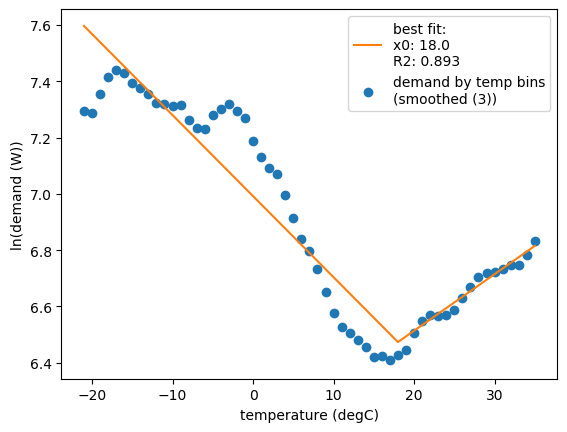

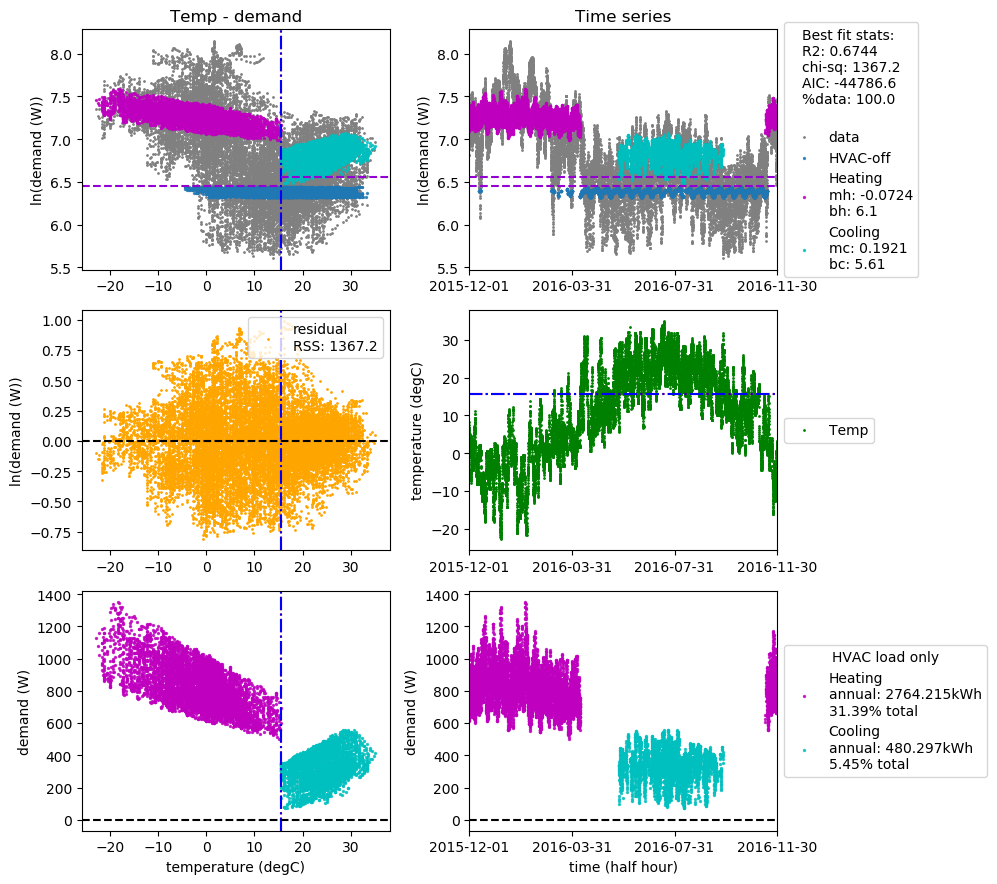

In [20]:
print('Single run...')
fourier_type = '82' # <---------- # 44, 42, 82
multi_init = True # <--------- # if using 5 sets of initial val
log_transform = True # <------- # if modeling data as log(data) 
in_W = True # <------- load data in [W]
service_type = 'C26' # <--------
create_plot = True
return_output = True
fig_ext = 'pdf'

ylog_msg = 'log' if log_transform else ''

#### define season
# heat1e = pd.Timestamp('2016-05-01') #
# cools = pd.Timestamp('2016-06-01') #
# coole = pd.Timestamp('2016-09-01') #
# heat2s = pd.Timestamp('2016-10-01') #

# seasons by rupture
heat1e = pd.Timestamp('2016-04-11') 
cools = pd.Timestamp('2016-05-26') 
coole = pd.Timestamp('2016-09-28') 
heat2s = pd.Timestamp('2016-11-17') 

# tseason
tseason = np.array([heat1e, cools, coole, heat2s]) - np.array([pd.Timestamp('2015-12-01')])
tseason = np.array([i.days*24 + i.seconds/3600 for i in tseason])

### load data
print('>>> load data: {} in {} [{}W]'.format(service_type, data_type, ylog_msg))
df_temp, df_demand, fft, fftn, ffth, fftc = data_set_up(service_type, in_W, log_transform)

outdir_sub = folder_set_up(service_type, fourier_type, log_transform)
print('    output directory: ',outdir_sub)

zc = df_demand.columns[4] # <-------
print('{}-{}'.format(service_type, zc))
Output = run_model(zc, fourier_type, 'powell', multi_init, log_transform, 
              create_plot, fig_ext, return_output)

>>> best interation:


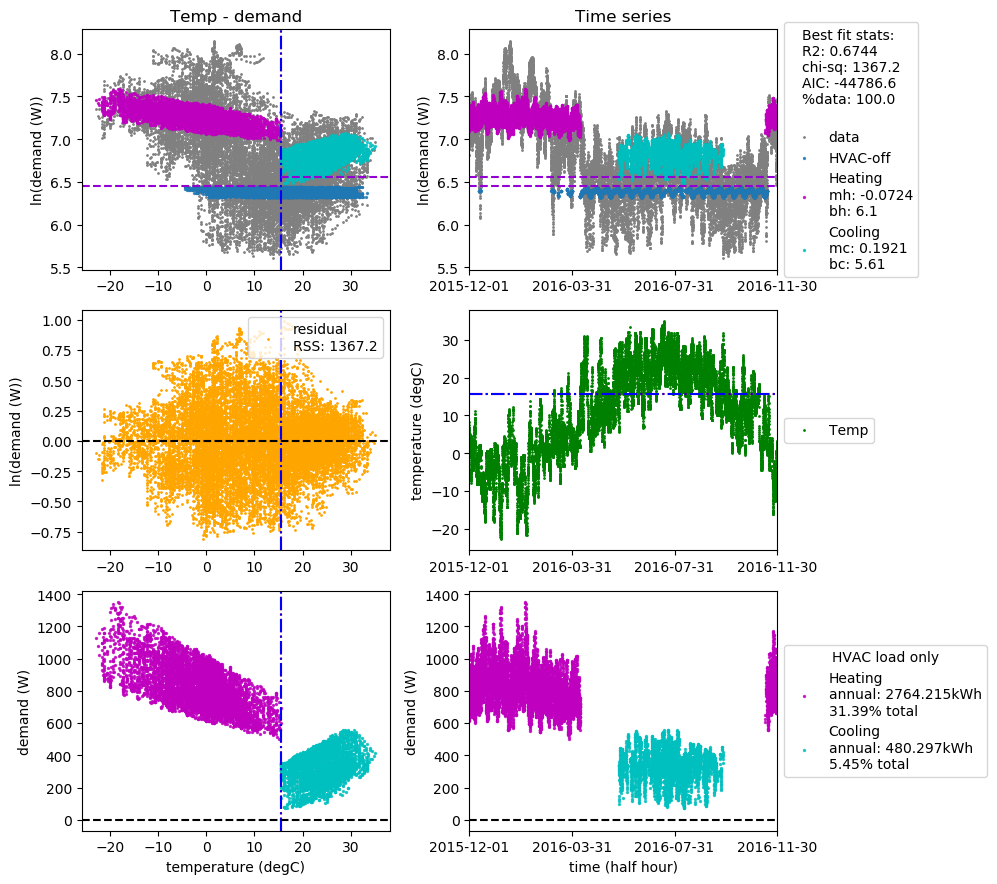

In [21]:
### test "load_pickle_and_plot" func
load_pickle_and_plot(zc, service_type, fourier_type, log_transform, fig_ext='pdf')
# Output callout examples
#Output['data']['demand'] # data
print('>>> best interation:')
#Output['df_val'].iloc[Output['opt']] # result df from all iterations

### check completion status

In [17]:
########## check completion status ###########
fourier_type = '44' # <---------- # '44' or '42' or '82'
multi_init = True # <--------- # if using 5 sets of initial val
log_transform = True # <------- # if modeling data as log(data)
in_W = True # <------- load data in [W]
fig_ext = 'pdf' # <---- 'png', 'pdf', None (no save)

ylog_msg = 'log ' if log_transform else ''


for counter, typ in enumerate(['C26','C25','C24','C23','C23'],1):
    # need to break 'C23' into two partitions
    service_type = typ

    print('>>> {}. load data: {} in {} [{}W]...'.format(counter, service_type, data_type, ylog_msg))

    ########## check if folder exists, else create one
    outdir_sub = folder_set_up(service_type, fourier_type, log_transform)
    print('    output directory: ',outdir_sub)

    ts1 = pd.Timestamp('2015-12-01')
    ts2 = pd.Timestamp('2016-12-01')

    Nzipcodes = len(DF[service_type].query('(time>=@ts1)&(time<@ts2)')['zip_code'].unique())
            
    ########## put into dask list
    
    # get completed list
    completed_list = list(os.path.splitext(os.path.basename(y))[0][-5:] for y in
        list(filter(lambda x: x.endswith('.pkl'), os.listdir(outdir_sub))))
    completed_list = list(map(int, completed_list))

    print('>>> {}. completed: {} / {} zip codes from {} - {} [{}W]...'.format(counter, 
                        len(completed_list), Nzipcodes, service_type, data_type, ylog_msg))

    
    ########## plot 50 from list
    # get plotted list
    plotted_list = list(os.path.splitext(os.path.basename(y))[0][-5:] for y in
        list(filter(lambda x: x.endswith('.{}'.format(fig_ext)),
                       os.listdir(os.path.join(outdir_sub,'plots')))))
    plotted_list = list(map(int, plotted_list))
    
    list_to_plot_remain = [x for x in completed_list if x not in plotted_list] # filter out completed zip codes
    print('>>> {}. completed {} / {} plots...'.format(counter, len(plotted_list), Nzipcodes))
    

>>> 1. load data: C26 in half_hourly [W]...
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model44__C26_half_hourly
>>> 1. completed: 0 / 205 zip codes from C26 - half_hourly [W]...
>>> 1. completed 0 / 205 plots...
>>> 2. load data: C25 in half_hourly [W]...
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model44__C25_half_hourly
>>> 2. completed: 0 / 141 zip codes from C25 - half_hourly [W]...
>>> 2. completed 0 / 141 plots...
>>> 3. load data: C24 in half_hourly [W]...
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model44__C24_half_hourly
>>> 3. completed: 0 / 245 zip codes from C24 - half_hourly [W]...
>>> 3. completed 0 / 245 plots...
>>> 4. load data: C23 in half_hourly [W]...
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model44__C23_half_hourly
>>> 4. completed: 0 / 350 zip codes from C23 - half_hourly [W]...
>>> 4. completed 0 / 350 plots

# Dask run panel: change-point model

In [ ]:
########## data prep
fourier_type = '82' # <---------- # '44' or '42' or '82'
multi_init = True # <--------- # if using 5 sets of initial val
log_transform = False # <------- # if modeling data as log(data)
in_W = True # <------- load data in [W]
fig_ext = 'pdf' # <---- 'png', 'pdf', None (no save)

ylog_msg = 'log ' if log_transform else ''

method_list = ['leastsq','least_squares','differential_evolution','brute','basinhopping','ampgo','nelder',
                       'lbfgsb','powell','cg','newton','cobyla','bfgs','tnc','trust-ncg','trust-exact',
                       'trust-krylov','trust-constr','dogleg','slsqp','emcee','dual_annealing']

#### define seasons
# (1) seasons used by EULP
#heat1e = pd.Timestamp('2016-05-01') #
#cools = pd.Timestamp('2016-06-01') #
#coole = pd.Timestamp('2016-09-01') #
#heat2s = pd.Timestamp('2016-10-01') #

# (2) seasons defined by rupture output
heat1e = pd.Timestamp('2016-04-11') 
cools = pd.Timestamp('2016-05-26') 
coole = pd.Timestamp('2016-09-28') 
heat2s = pd.Timestamp('2016-11-17') 

# tseason
tseason = np.array([heat1e, cools, coole, heat2s]) - np.array([pd.Timestamp('2015-12-01')])
tseason = np.array([i.days*24 + i.seconds/3600 for i in tseason])

for counter, typ in enumerate(['C26','C25','C24','C23','C23'],1):
    # need to break 'C23' into two partitions
    service_type = typ

    print('>>> {}. load data: {} in {} [{}W]...'.format(counter, service_type, data_type, ylog_msg))
    df_temp, df_demand, fft, fftn, ffth, fftc = data_set_up(service_type, in_W, log_transform)

    ########## check if folder exists, else create one
    outdir_sub = folder_set_up(service_type, fourier_type, log_transform)
    print('    output directory: ',outdir_sub)

    method = 'powell' # <------ see method_list above
    zipcode_list = df_demand.columns.values
    N_plots = 'all' # <----- # of zipcodes to plot in service class
    
    if N_plots.isnumeric():
        random.seed(a=5) # control the randomness
        list_to_plot = random.sample(set(zipcode_list), N_plots)
    else:
        list_to_plot = zipcode_list

    ########## put into dask list
    
    # get completed list
    completed_list = list(os.path.splitext(os.path.basename(y))[0][-5:] for y in
        list(filter(lambda x: x.endswith('.pkl'), os.listdir(outdir_sub))))
    completed_list = list(map(int, completed_list))
    
    list_to_compute = [x for x in zipcode_list if x not in completed_list] # filter out completed zip codes
    if service_type == 'C23':
        list_to_compute = list_to_compute[:min(175, len(list_to_compute))] # split C23 into two partitions
                 
    #% assemble dask list
    model_list = list(map(delayed(functools.partial(
        run_model, fourier_type=fourier_type, method=method, multi_init=multi_init, log_transform=log_transform, 
              create_plot=True, fig_ext=fig_ext, return_output=False)), list_to_compute))
    print('>>> {}. dask list compiled for {} / {} zip codes from {} - {} [{}W]...'.format(counter, 
                        len(list_to_compute), len(zipcode_list), service_type, data_type, ylog_msg))
    #% run
    model_list = get_ipython().run_cell_magic('time', '', 'dask.compute(*model_list)') #list
    print('    >>> {}. dask compute completed!'.format(counter))

    
    ########## plot from list
    # get plotted list
    plotted_list = list(os.path.splitext(os.path.basename(y))[0][-5:] for y in
        list(filter(lambda x: x.endswith('.{}'.format(fig_ext)),
                       os.listdir(os.path.join(outdir_sub,'plots')))))
    plotted_list = list(map(int, plotted_list))
    
    completed_list = list(os.path.splitext(os.path.basename(y))[0][-5:] for y in
        list(filter(lambda x: x.endswith('.pkl'), os.listdir(outdir_sub))))
    completed_list = list(map(int, completed_list))
    
    list_to_plot_remain = [x for x in completed_list if x not in plotted_list] # filter out completed zip codes
    print('>>> {}. {} / {} plots to create...'.format(counter, len(list_to_plot_remain), len(zipcode_list)))
    
    plot_all = list(map(delayed(functools.partial(
        load_pickle_and_plot, service_type=service_type, fourier_type=fourier_type, 
        log_transform=log_transform, fig_ext=fig_ext)), list_to_plot_remain))
    #% run
    plot_all = get_ipython().run_cell_magic('time', '', 'dask.compute(*plot_all)') #list

    print('    >>> {}. Plotting completed.'.format(counter))
        
    

>>> 1. load data: C26 in half_hourly [W]...
    data is in [W(h)]
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model44__C26_half_hourly
>>> 1. dask list compiled for 0 / 205 zip codes from C26 - half_hourly [W]...
CPU times: user 36 µs, sys: 12 µs, total: 48 µs
Wall time: 44.3 µs
    >>> 1. dask compute completed!
>>> 1. 0 / 205 plots to create...
CPU times: user 26 µs, sys: 8 µs, total: 34 µs
Wall time: 30.5 µs
    >>> 1. Plotting completed.
>>> 2. load data: C25 in half_hourly [W]...
    data is in [W(h)]
    output directory:  /projects/enduse/ComEd_zipplus4_results/DR_heating_cooling/Model44__C25_half_hourly
>>> 2. dask list compiled for 70 / 141 zip codes from C25 - half_hourly [W]...


When you're all done, you can kill all the worker jobs with the following command. They will be closed anyway if you close and halt the notebook.

In [ ]:
cluster.stop_all_jobs()

In [ ]:
len(cluster.running_jobs)